In [1]:
from gerrychain import Graph

In [2]:
# Read Oklahoma county graph from the json file "OK_county.json"
filepath = 'C:\\districting-data\\'
filename = 'OK_county.json'

# GerryChain has a built-in function for reading graphs of this type:
G = Graph.from_json( filepath + filename )

In [3]:
# For each node, print the node #, county name, and its population
for node in G.nodes:
    name = G.nodes[node]["NAME10"]
    population = G.nodes[node]['TOTPOP']
    print("Node",node,"represents",name,"County and its population in year 2010 was",population)

Node 0 represents Payne County and its population in year 2010 was 77350
Node 1 represents Caddo County and its population in year 2010 was 29600
Node 2 represents Delaware County and its population in year 2010 was 41487
Node 3 represents Marshall County and its population in year 2010 was 15840
Node 4 represents Greer County and its population in year 2010 was 6239
Node 5 represents Coal County and its population in year 2010 was 5925
Node 6 represents Seminole County and its population in year 2010 was 25482
Node 7 represents Murray County and its population in year 2010 was 13488
Node 8 represents Jefferson County and its population in year 2010 was 6472
Node 9 represents Tillman County and its population in year 2010 was 7992
Node 10 represents McIntosh County and its population in year 2010 was 20252
Node 11 represents Choctaw County and its population in year 2010 was 15205
Node 12 represents Harper County and its population in year 2010 was 3685
Node 13 represents Grant County 

In [4]:
# We will instead use 2019 population numbers. Numbers are taken from:
#    https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/counties/asrh/cc-est2019-alldata-40.csv

population_2019 = {
        'Adair' : 22194,
        'Alfalfa' : 5702,
        'Atoka' : 13758,
        'Beaver' : 5311,
        'Beckham' : 21859,
        'Blaine' : 9429,
        'Bryan' : 47995,
        'Caddo' : 28762,
        'Canadian' : 148306,
        'Carter' : 48111,
        'Cherokee' : 48657,
        'Choctaw' : 14672,
        'Cimarron' : 2137,
        'Cleveland' : 284014,
        'Coal' : 5495,
        'Comanche' : 120749,
        'Cotton' : 5666,
        'Craig' : 14142,
        'Creek' : 71522,
        'Custer' : 29003,
        'Delaware' : 43009,
        'Dewey' : 4891,
        'Ellis' : 3859,
        'Garfield' : 61056,
        'Garvin' : 27711,
        'Grady' : 55834,
        'Grant' : 4333,
        'Greer' : 5712,
        'Harmon' : 2653,
        'Harper' : 3688,
        'Haskell' : 12627,
        'Hughes' : 13279,
        'Jackson' : 24530,
        'Jefferson' : 6002,
        'Johnston' : 11085,
        'Kay' : 43538,
        'Kingfisher' : 15765,
        'Kiowa' : 8708,
        'Latimer' : 10073,
        'Le Flore' : 49853,
        'Lincoln' : 34877,
        'Logan' : 48011,
        'Love' : 10253,
        'McClain' : 40474,
        'McCurtain' : 32832,
        'McIntosh' : 19596,
        'Major' : 7629,
        'Marshall' : 16931,
        'Mayes' : 41100,
        'Murray' : 14073,
        'Muskogee' : 67997,
        'Noble' : 11131,
        'Nowata' : 10076,
        'Okfuskee' : 11993,
        'Oklahoma' : 797434,
        'Okmulgee' : 38465,
        'Osage' : 46963,
        'Ottawa' : 31127,
        'Pawnee' : 16376,
        'Payne' : 81784,
        'Pittsburg' : 43654,
        'Pontotoc' : 38284,
        'Pottawatomie' : 72592,
        'Pushmataha' : 11096,
        'Roger Mills' : 3583,
        'Rogers' : 92459,
        'Seminole' : 24258,
        'Sequoyah' : 41569,
        'Stephens' : 43143,
        'Texas' : 19983,
        'Tillman' : 7250,
        'Tulsa' : 651552,
        'Wagoner' : 81289,
        'Washington' : 51527,
        'Washita' : 10916,
        'Woods' : 8793,
        'Woodward' : 20211                   
}

In [5]:
for node in G.nodes:
    name = G.nodes[node]["NAME10"]
    G.nodes[node]['POP19'] = population_2019[name]
    
print("population of Payne County is",G.nodes[0]['POP19'])

population of Payne County is 81784


In [6]:
# what is the total 2019 population?
total_population_2019 = sum( G.nodes[i]['POP19'] for i in G.nodes )

# Let's set lower and upper population bounds on the districts
k = 48              # number of districts
deviation = 0.05     # 5% deviation (+/-2.5%)

import math
L = math.ceil( (1 - deviation / 2) * total_population_2019 / k )
U = math.floor( (1 + deviation / 2) * total_population_2019 / k )

print("Desired number of districts =",k)
print("Lower population threshold =",L)
print("Upper population threshold =",U)

Desired number of districts = 48
Lower population threshold = 80376
Upper population threshold = 84497


In [7]:
# Let's find a large subset of counties B with the property 
#    that every component of G[B] has population less than L.
#
# This is used to help speed up the computations, but has no 
#    bearing on the final results themselves.

import networkx as nx
DG = nx.DiGraph(G) # bidirected version of G

import gurobipy as gp
from gurobipy import GRB

bm = gp.Model()

# X[i,j]=1 if vertex i is assigned to bin j
bX = bm.addVars(DG.nodes, k, vtype=GRB.BINARY) 

# B[i]=1 if vertex i is selected
bB = bm.addVars(DG.nodes, vtype=GRB.BINARY)

# set objective, maximize number of vertices in B
bm.setObjective( gp.quicksum( bB[i] for i in DG.nodes ), GRB.MAXIMIZE )

# relate X and B vars
bm.addConstrs( bB[i] == gp.quicksum( bX[i,j] for j in range(k) ) for i in DG.nodes)

# bin capacity constraints
bm.addConstrs( gp.quicksum( G.nodes[i]['POP19'] * bX[i,j] for i in G.nodes ) <= L-1 for j in range(k) )

# bin conflict constraints
bm.addConstrs( bX[u,j] + bB[v] <= 1 + bX[v,j] for u,v in DG.edges for j in range(k) )

# solve and return B
bm.Params.TimeLimit = 60
bm.optimize()

B = [i for i in DG.nodes if bB[i].x > 0.5]
B_names = [ G.nodes[i]['NAME10'] for i in B ]

print("B =",B)
print("B county names =",B_names)

Academic license - for non-commercial use only - expires 2021-04-22
Using license file C:\Users\buchanan\gurobi.lic
Changed value of parameter TimeLimit to 60.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 18845 rows, 3773 columns and 63629 nonzeros
Model fingerprint: 0x4589707b
Variable types: 0 continuous, 3773 integer (3773 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+04]
Found heuristic solution: objective -0.0000000
Presolve removed 3848 rows and 392 columns
Presolve time: 0.10s
Presolved: 14997 rows, 3381 columns, 51333 nonzeros
Variable types: 0 continuous, 3381 integer (3381 binary)

Root relaxation: objective 6.900000e+01, 6005 iterations, 0.98 seconds

    Nodes    |    Current Node    |     Objective Bound

In [8]:
# function used in sorting step in an upcoming cell
def sort_by_second(val):
    return val[1]   

In [9]:
# Solve county clustering problem:
#
# Group the counties into contiguous clusters so that each has
#   population that is an integer multiple of the ideal population     
#

m = gp.Model()

# X[i,j]=1 if vertex i is assigned to (cluster centered at) vertex j
X = m.addVars(DG.nodes, DG.nodes, vtype=GRB.BINARY) 

# Y[j] = # of clusters centered at vertex j
Y = m.addVars(DG.nodes, vtype=GRB.INTEGER)

# Set objective function, maximize number of clusters
m.setObjective( gp.quicksum( X[j,j] for j in DG.nodes ), GRB.MAXIMIZE ) 

In [10]:
# Add base constraints

# Each county i assigned to one cluster
m.addConstrs( gp.quicksum( X[i,j] for j in DG.nodes ) == 1 for i in DG.nodes )

# Cluster "sizes" should sum to k
m.addConstr( gp.quicksum(Y[j] for j in DG.nodes) == k )

# Population balance: population of cluster j should be in [L,U] * Y[j]
m.addConstrs( gp.quicksum( G.nodes[i]['POP19'] * X[i,j] for i in DG.nodes ) <= U * Y[j] for j in DG.nodes )
m.addConstrs( gp.quicksum( G.nodes[i]['POP19'] * X[i,j] for i in DG.nodes ) >= L * Y[j] for j in DG.nodes )

# Enforce relationships between X[i,j] and X[j,j] and Y[j]
m.addConstrs( X[j,j] <= Y[j] for j in DG.nodes )
m.addConstrs( Y[j] <= DG.number_of_nodes() * X[j,j] for j in DG.nodes )
m.addConstrs(X[i,j] <= X[j,j] for i in DG.nodes for j in DG.nodes)

m.update()

In [11]:
# Add contiguity constraints

# F[j,u,v] tells how much flow (from source j) is sent across arc (u,v)
F = m.addVars(DG.nodes, DG.edges, vtype=GRB.CONTINUOUS)
M = DG.number_of_nodes() - 1
for j in DG.nodes:
    m.addConstr( sum(F[j,u,j] for u in DG.neighbors(j) ) == 0 )
    for i in DG.nodes:
        if i!=j:
            m.addConstr( sum(F[j,u,i] for u in DG.neighbors(i) ) - sum(F[j,i,u] for u in DG.neighbors(i)) == X[i,j] )
            m.addConstr( sum(F[j,u,i] for u in DG.neighbors(i) ) <= M * X[i,j] )

In [12]:
# This cell: computational speedups 

# Set branch priority on center vars
for j in DG.nodes:
    X[j,j].BranchPriority = 1
    Y[j].BranchPriority = 1
        
# Variable fixing based on set B
V_B_with_population = [(i,G.nodes[i]['POP19']) for i in G.nodes if i not in B]
V_B_with_population.sort(key=sort_by_second,reverse=True)
ordering = [v for (v,p) in V_B_with_population] + B   

# diagonal fixing based on ordering
for p in range(len(ordering)):
    i = ordering[p]
    for q in range(p+1,len(ordering)):
        j = ordering[q]
        X[i,j].UB = 0

# L fixing
for i in DG.nodes:
    for j in B:
        X[i,j].UB = 0

In [13]:
# solve
m.Params.TimeLimit = 7200 # 2-hour time limit
m.optimize()

Changed value of parameter TimeLimit to 7200.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 18096 rows, 36036 columns and 131044 nonzeros
Model fingerprint: 0x4a3d2baf
Variable types: 30030 continuous, 6006 integer (5929 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Presolve removed 11958 rows and 25986 columns
Presolve time: 0.27s
Presolved: 6138 rows, 10050 columns, 38095 nonzeros
Variable types: 7927 continuous, 2123 integer (2084 binary)
Found heuristic solution: objective 2.0000000

Root relaxation: objective 2.907821e+01, 4140 iterations, 0.49 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0 

  1133   838   23.85873   18  563   18.00000   23.85873  32.5%  2058  392s
  1135   839   22.00000   35  525   18.00000   23.85193  32.5%  2054  395s
  1139   842   23.83368   16  518   18.00000   23.83368  32.4%  2047  400s
  1143   844   22.95957   29  560   18.00000   23.82236  32.3%  2040  406s
  1146   846   23.00000   32  626   18.00000   23.81673  32.3%  2034  410s
  1148   848   23.81176   20  597   18.00000   23.81176  32.3%  2031  416s
  1152   850   21.99910   44  563   18.00000   23.80665  32.3%  2024  420s
  1154   852   23.80427   16  628   18.00000   23.80427  32.2%  2020  425s
  1158   854   23.79542   14  609   18.00000   23.79542  32.2%  2013  430s
  1162   857   23.00000   30  572   18.00000   23.79020  32.2%  2006  436s
  1164   858   23.78785   11  620   18.00000   23.78785  32.2%  2003  440s
  1167   860   23.78320   17  602   18.00000   23.78320  32.1%  1998  446s
  1169   862   23.77972   18  597   18.00000   23.77972  32.1%  1994  450s
  1172   864   23.77546  

  1550  1076   22.45282   47  459   19.00000   23.49698  23.7%  2431  960s
  1571  1089   22.91008   50  402   19.00000   23.49698  23.7%  2425  968s
  1581  1094   22.83835   52  345   19.00000   23.49698  23.7%  2419  973s
  1589  1097   22.82659   53  365   19.00000   23.49698  23.7%  2414  976s
  1599  1106   22.81844   54  353   19.00000   23.49698  23.7%  2411  981s
  1611  1114   22.81770   56  349   19.00000   23.49698  23.7%  2408  985s
  1634  1133   22.80976   60  336   19.00000   23.49698  23.7%  2402  992s
  1650  1146   22.61470   61  288   19.00000   23.49698  23.7%  2394  995s
  1684  1162   22.00000   65  212   19.00000   23.49698  23.7%  2376 1003s
  1699  1171   22.00000   67  164   19.00000   23.49698  23.7%  2375 1007s
  1719  1187   21.85506   70  304   19.00000   23.49698  23.7%  2378 1011s
H 1724  1132                      20.0000000   23.49698  17.5%  2374 1011s
  1777  1151   21.00000   75  175   20.00000   23.49698  17.5%  2349 1019s
  1807  1154   21.52080  

 20965 10435   22.71755   59  391   21.00000   23.21019  10.5%  1811 4355s
 20967 10436   22.21955   55  522   21.00000   23.21019  10.5%  1811 4363s
 20968 10437   22.66287   63  484   21.00000   23.21019  10.5%  1810 4366s
 20969 10438   22.00000   68  446   21.00000   23.21019  10.5%  1810 4370s
 20971 10439   22.66191   68  494   21.00000   23.21019  10.5%  1810 4379s
 20972 10440   22.78389   63  466   21.00000   23.21019  10.5%  1810 4382s
 20973 10440   22.63135   68  487   21.00000   23.21019  10.5%  1810 4388s
 20974 10441   22.16059   65  484   21.00000   23.21019  10.5%  1810 4391s
 20975 10442   23.00000   67  504   21.00000   23.21019  10.5%  1810 4395s
 20977 10443   22.00000   66  512   21.00000   23.21019  10.5%  1810 4401s
 20979 10444   22.00000   64  511   21.00000   23.21019  10.5%  1809 4407s
 20980 10445   22.52431   57  520   21.00000   23.21019  10.5%  1809 4410s
 20982 10446   22.92655   51  529   21.00000   23.21019  10.5%  1809 4418s
 20983 10447   22.45117  

 21185 10582   22.68277   65  502   21.00000   23.21019  10.5%  1792 4912s
 21187 10583   22.67303   63  535   21.00000   23.21019  10.5%  1792 4915s
 21189 10584   22.79745   64  533   21.00000   23.21019  10.5%  1792 4921s
 21191 10586   22.65806   60  536   21.00000   23.21019  10.5%  1791 4925s
 21193 10587   22.96691   45  516   21.00000   23.21019  10.5%  1791 4931s
 21195 10588   23.16142   59  521   21.00000   23.21019  10.5%  1791 4935s
 21198 10590   22.91178   61  507   21.00000   23.21019  10.5%  1791 4941s
 21200 10592   22.92871   51  513   21.00000   23.21019  10.5%  1791 4946s
 21202 10593   23.20363   56  509   21.00000   23.21019  10.5%  1790 4955s
 21203 10594   22.74186   59  509   21.00000   23.21019  10.5%  1790 4980s
 21204 10597   23.21019   51  447   21.00000   23.21019  10.5%  1810 5004s
 21206 10601   23.21019   52  413   21.00000   23.21019  10.5%  1810 5035s
 21210 10603   23.21019   53  460   21.00000   23.21019  10.5%  1811 5064s
 21214 10606   23.21019  

In [14]:
# What are the cluster "centers"?
centers = [j for j in DG.nodes if Y[j].x > 0.5]

print("********************************")
print("********************************")

# Print info about each cluster
clusters = list()
for j in centers:
    cluster_nodes = [ i for i in DG.nodes if X[i,j].x > 0.5 ]
    cluster_names = [ G.nodes[i]['NAME10'] for i in cluster_nodes ]
    cluster_population = sum( G.nodes[node]['POP19'] for node in cluster_nodes )
    cluster_size = int(Y[j].x)
    print("Cluster rooted at node",j,"(",G.nodes[j]['NAME10']," County ) has total population",cluster_population,"and should be split into",cluster_size,"district(s).")
    print("Cluster nodes are",cluster_nodes,"which correspond to counties:",cluster_names)
    print("Average district in this cluster should have population",cluster_population/cluster_size)
    print("********************************")
    print("********************************")
    clusters.append(cluster_nodes)
    
print("There are",len(clusters),"clusters:",clusters)

********************************
********************************
Cluster rooted at node 0 ( Payne  County ) has total population 81784 and should be split into 1 district(s).
Cluster nodes are [0] which correspond to counties: ['Payne']
Average district in this cluster should have population 81784.0
********************************
********************************
Cluster rooted at node 15 ( Oklahoma  County ) has total population 974502 and should be split into 12 district(s).
Cluster nodes are [1, 15, 68] which correspond to counties: ['Caddo', 'Oklahoma', 'Canadian']
Average district in this cluster should have population 81208.5
********************************
********************************
Cluster rooted at node 20 ( Pontotoc  County ) has total population 82110 and should be split into 1 district(s).
Cluster nodes are [5, 6, 7, 20] which correspond to counties: ['Coal', 'Seminole', 'Murray', 'Pontotoc']
Average district in this cluster should have population 82110.0
*********

In [15]:
# Map the clusters
import geopandas as gpd

filepath = 'C:\\districting-data\\'
filename = 'OK_county.shp'
df = gpd.read_file( filepath + filename )

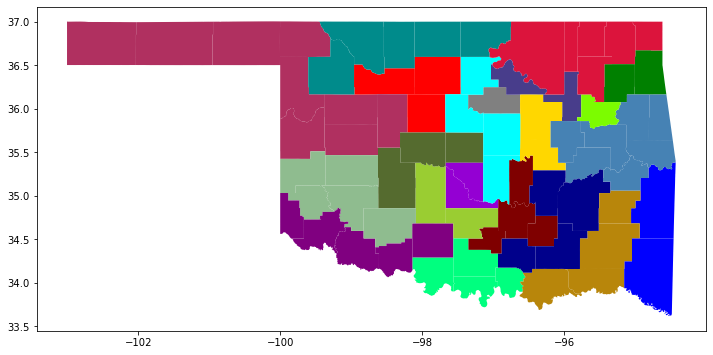

In [16]:
# Which cluster is each county assigned to?
assignment = [ -1 for u in G.nodes ]
    
# for each district j
for j in range(len(clusters)):
    
    # for each node i in this cluster
    for i in clusters[j]:
        
        # What is its GEOID?
        geoID = G.nodes[i]["GEOID10"]
        
        # Need to find this GEOID in the dataframe
        for u in G.nodes:
            if geoID == df['GEOID10'][u]: # Found it
                assignment[u] = j # Node u from the dataframe should be assigned to district j

# Now add the assignments to a column of the dataframe and map it
pallette = ['#808080','#556b2f','#7f0000','#483d8b','#008000','#b8860b','#008b8b','#4682b4','#9acd32','#00008b','#8fbc8f','#800080','#b03060','#ff0000','#ffd700','#7cfc00','#9400d3','#00ff7f','#dc143c','#00ffff','#0000ff','#da70d6','#1e90ff','#fa8072','#90ee90','#add8e6','#ff1493','#7b68ee','#ffdead','#ffb6c1']
colors = [pallette[assignment[node]] for node in G.nodes]
df['colors'] = colors
my_fig = df.plot(color=df['colors']).get_figure()
RESIZE_FACTOR = 2
my_fig.set_size_inches(my_fig.get_size_inches()*RESIZE_FACTOR)

In [17]:
# The county clusters can be split in many, many ways. Here is one possible way
import webbrowser

webbrowser.open('https://davesredistricting.org/join/090b7e12-9eed-4d36-a910-f5d95a53ae93')  

True